<a href="https://colab.research.google.com/github/dmitr2ish/MOMO_2023/blob/main/%D0%9B%D0%BE%D0%B3%D0%B8%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D0%A0%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D1%8F_%D0%A1%D0%B8%D0%BD%D1%82%D0%B5%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%B5_%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D0%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Импорт


In [ ]:
import numpy as np # библиотека Numpy для операций линейной алгебры и прочего
import pandas as pd # Библиотека Pandas для работы с табличными данными

import matplotlib.pyplot as plt # библиотека Matplotlib для визуализации
from matplotlib.colors import ListedColormap # функция библиотеки Matplotlib, которая генерирует цветовую карту

from sklearn.datasets import make_moons, make_circles, make_classification # генерируемые наборы данных

from sklearn.model_selection import train_test_split #  функция разбиения на тренировочную и тестовую выборку
# но в исполнении scikit-learn

import plotly.graph_objects as go # Библиотека Plotly. Модуль "Graph Objects"
import plotly.express as px # Библиотека Plotly. Модуль "Express"

если **не** хотите рисунки на темном фоне **не** выполняйте следующую ячейку

In [ ]:
plt.style.use('dark_background')

Из блокнота про [Линейную регрессию](https://colab.research.google.com/drive/1sP0qdbA-ecRQrcE9S_JiVsFIapy11VpN?usp=sharing) мы просто копируем написанные нами ранее классы

Класс Линейной Регрессии, как базовую модель

In [ ]:
class LinearRegression():
    def __init__(self,
                 learning_rate = 0.5,
                 epochs = 100,
                 weights = None,
                 bias    = None,
                 batch_size   = 1000,
                 n_batches    = None,
                 random_state = 42):
        self.lr      = learning_rate
        self.epochs  = epochs
        self.weights = weights
        self.bias    = bias
        self.seed    = random_state
        self.batch_size = batch_size
        self.cost    = np.zeros(epochs)
        self.n_batches = n_batches


    #---------------------------------
    def forward(self, X):
        # умножаем признаки на веса
        return np.dot(X, self.weights)

    #---------------------------------
    def loss(self,yhat, y):
        # расчет функции потерь
        return np.square(yhat - y).sum()/y.size

    #---------------------------------
    def grad_step(self,yhat, y, X):
        # расчет градиента
        return 2*np.dot(X.T, (yhat - y)) / y.size

    #---------------------------------
    def update(self):
        # обновление весов
        return self.weights - self.lr*self.grad

    #---------------------------------
    def init(self, weights_size):
        # инициализируем веса
        np.random.seed(self.seed)
        return np.random.randn(weights_size)/np.sqrt(weights_size)

    #---------------------------------
    def predict(self, X):
        # делем предсказание модели
        yhat = self.forward(self.add_bias(X))
        return yhat.squeeze()

    #---------------------------------
    def score(self, X, y):
        # оценка по коэффициенту детерминации
        yhat = self.predict(X)
        return 1-np.sum(np.square(y-yhat))/np.sum(np.square(y-np.mean(y)))

    #---------------------------------
    def fit(self, X, y):
        # обучение модели с учетом разбиения на батчи
        np.random.seed(self.seed)

        if self.weights is None: # если веса не заданы - задаем
            self.weights = self.init(X.shape[1])

        if self.bias is None: # если смещение не задано - задаем
            self.bias    = self.init(1)

        if self.weights.size == X.shape[1]: # если веса заданы, но не добавлено смещение - объединяем
            self.weights = np.append(self.bias,self.weights)

        self.grad    = np.zeros(self.weights.shape)
        self.cost    = np.zeros(self.epochs)

        if self.batch_size is None:   # проверка на согласование размерности батча и размерности данных
            self.batch_size = y.size

        if self.n_batches is None:
            self.n_batches = y.size//self.batch_size

        for i in range(self.epochs): #циклы обучения, как раньше
            loss = 0
            for cnt,(x_batch, y_batch) in enumerate(self.load_batch(X,y)):

                yhat         = self.forward(x_batch)
                self.grad    = self.grad_step(yhat,  y_batch, x_batch)
                self.weights = self.update()
                loss += self.loss(yhat,  y_batch)

                if cnt>= self.n_batches:
                    break
            self.cost[i] = loss/self.n_batches

        self.bias = self.weights[0]
    #---------------------------------
    def load_batch(self,X,y):
        # загрузка батча
        idxs = np.arange(y.size)
        np.random.shuffle(idxs)

        for i_batch in range(0,y.size,self.batch_size):
            idx_batch = idxs[i_batch:i_batch+self.batch_size]
            x_batch   = np.take(X, idx_batch,axis=0)
            x_batch   = self.add_bias(x_batch) # тут мы всегда добавляем смещение
            y_batch   = np.take(y, idx_batch)
            yield  x_batch, y_batch

    #---------------------------------
    def add_bias(self, X):
        # добавление смещения
        return np.column_stack((np.ones(X.shape[0]), X))

    #---------------------------------
    def plot_cost(self, figsize = (12,6), title = 'Кривая обучения'):
        # отрисовка сразу в методе
        fig = go.Figure()
            # рисуем с помощью библиотеки plotly
        fig.add_trace(
                go.Scatter(
                y=self.cost,
                mode='lines+markers',
                name='Реальные данные',

                )
            )
        fig.update_layout(
                    title=title,
                    width=1200,
                    height=600,
                template = "plotly_dark"
                    )

        fig.show()

    #---------------------------------
    def get_w_and_b(self):
        # "новый" метод - который возвращает веса модели и смещение
        return (self.weights[1:], self.bias)

И класс Еластичной Регрессии, чтобы была регуляризация, которая бывает полезной для предотвращения переобучения

In [ ]:
class ElasticRegression(LinearRegression): #унаследуем всё что можно от "базовой" модели
    def __init__(self,
                 learning_rate = 0.5,
                 l1_penalty = 0.0,
                 l2_penalty = 0.0,
                 epochs = 100,
                 weights = None,
                 bias    = None,
                 batch_size   = 1000,
                 n_batches    = None,
                 random_state = 42):

        super().__init__(learning_rate = learning_rate,
                         epochs = epochs,
                         weights = weights,
                         bias    = bias,
                         batch_size   = batch_size,
                         n_batches    = n_batches,
                         random_state = random_state)
        self.l1_penalty = l1_penalty
        self.l2_penalty = l2_penalty

    #---------------------------------
    def loss(self,yhat, y):
        # изменяем функцию потерь
        l1_term = self.l1_penalty*np.sum(np.abs(self.weights[1:]))
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))
        return np.square(yhat - y).mean() + l1_term + l2_term

    #---------------------------------
    def update(self):
        # изменяем правило обновление весов
        l2_term = self.l2_penalty*np.sum(self.weights[1:])
        return self.weights - self.lr*(self.grad +  np.sign(self.weights)*self.l1_penalty + l2_term)

Добавим новую функцию, которая позволит нам отрисовывать двумерные данные для классификации

In [ ]:
def plot_data(ax,ds,name='',marker = 'o',colors =("#FF0000", '#0000FF'),alpha=0.7, s = 150, facecolor=True):
    """Визуализация двумерных  данных для классификации
    Входные переменные:
    ===========
    ax:
    ds: набор данных, содержащий признаки X и целевые метки y
    name: название графика
    marker: тип маркера - по умолчанию просто круги
    colors: цвета, которые будут использоваться для раскраски разных классов - по умолчанию Красный и Синий
    alpha: прозрачность маркеров
    s: размер маркера (~ квадрат радиуса)
    facecolor:
    """

    X, y = ds # распаковываем признаки и целевые метки в отдельные переменные

    cm_bright = ListedColormap(colors) # формируем цветовую карту из наших цветов
    ax.set_title(name, fontsize = 30) # прописываем название графика
    if facecolor: # если переменная задана - то просто рисуем скатерограмму по признакам с использованием параметров маркеров
        ax.scatter(X[:, 0], X[:, 1],
                   marker = marker, c=y,
                   cmap=cm_bright,s = s,
                   alpha =alpha)
    else: # иначе так же рисуем скатерограмму, но без
        ax.scatter(X[:, 0], X[:, 1],
                   marker = marker, c=y,
                   cmap=cm_bright,s = s,
                   facecolor = 'None',
                   alpha =alpha)
    # немного красоты и ля аккуратности
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5 # фиксируем минимальные и максимальные значения по горизонтали
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5 # фиксируем минимальные и максимальные значения по вертикали
    ax.grid(True)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())

In [ ]:
def vis_weigths(weights):
    """Отрисовка весов.
    Входные переменные:
    ===========
    weights: веса
    """
    numbers = np.arange(0,len(weights)) # создаем массив от 0 до количество весов-1
    tick_labels = np.array(['w'+str(num) for num in numbers]) # создаем "названия" весов


    fig = go.Figure()
    fig.add_trace(go.Bar(x=numbers[weights<0], y=weights[weights<0],
                    marker_color='red',
                    name='отрицательные веса'))
    fig.add_trace(go.Bar(x=numbers[weights>=0], y=weights[weights>=0],
                    marker_color='blue',
                    name='положительные веса'
                    ))

    fig.update_layout(
                title="Веса модели",
                width=1200,
                height=600,
                template = "plotly_dark",
                xaxis = dict(
                                         tickmode = 'array',
                                         tickvals = numbers,
                                         ticktext = tick_labels,
                                         )
                )

    fig.show()

# Про Данные

Попробуем создать несколько вариантов данных для классификации.

In [ ]:
def make_binary_clf(N, method = 'line',
                    noises = 0.15,
                    random_state = 42):
    """Создание синтетического набора данных
    для бинарной классификации
    Входные переменные:
    ===========
    N: количество точек
    method: тип набора данных
    noises: коэффициент ~ сила шума
    random_state: фиксированный сид случайных чисел (для повторяемости)
    """
    # фиксируем случайный seed
    if random_state: rng = np.random.RandomState(seed = random_state)

    if method == 'line' or method is None:
        # если выбран метод line (или никакой не задан)
        # то мы создаем набор данных с использованием функции make_classification
        # это будут линейно-разделимые данные
        X, y = make_classification(n_samples=N, # количество точек
                                   n_features=2, # количество признаков
                                   n_redundant=0, # количество бесполезных признаков
                                   n_informative=2,# количество информативных признаков
                                   n_clusters_per_class=1, # количество групп точек на класс
                                   class_sep=2, # количество классов
                                   random_state=random_state # фиксированный сид случайных чисел
                                   )
        X += np.random.randn(*X.shape) *noises # добавляем к признакам случайный шум

    elif method == 'moons':
        # если выбран метод moons
        # то мы создаем набор данных с использованием функции make_moons
        # это будут данные похожие на Инь-Ян
        X, y = make_moons(n_samples=N, # количество точек
                          noise=noises, # уровень шума
                          random_state=random_state # фиксированный сид случайных чисел
                          )

    elif method == 'circles':
        # если выбран метод circles
        # то мы создаем набор данных с использованием функции make_circles
        # это будут данные в виде концентрических окружностей
        X, y = make_circles(n_samples=N, # количество точек
                            noise=noises, # уровень шума
                            factor=0.5, # соотношение радиусов внуренней и внешней окружности
                            random_state=random_state # фиксированный сид случайных чисел
                            )


    return X,y

Протестируем

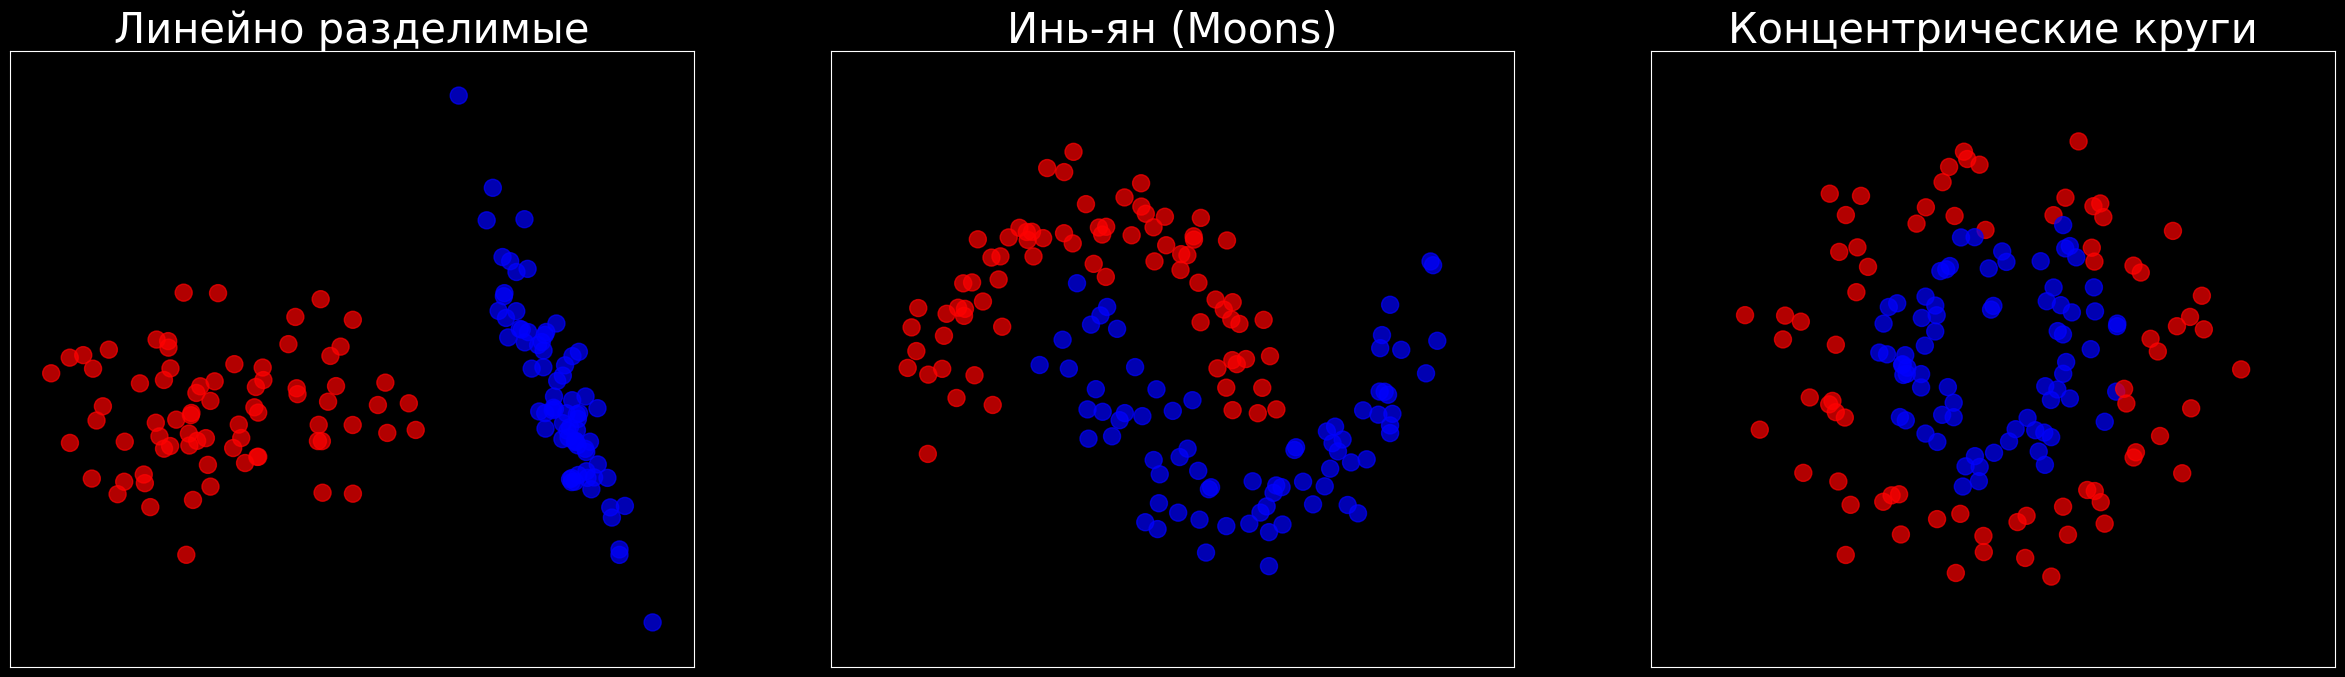

In [ ]:
#@title данные { run: "auto" }
N = 200 #@param {type:"slider", min:50, max:250, step:25}
noises = 0.4 #@param {type:"slider", min:0, max:1, step:0.05}
# слайдерами можно изменять количество точек и уровень шума
# И - Интерактивностб

fig=plt.figure(figsize=(30,8))

ax = plt.subplot(1, 3, 1)
plot_data(ax,make_binary_clf(N,method = 'line'),
          'Линейно разделимые')
ax = plt.subplot(1, 3, 2)
plot_data(ax,make_binary_clf(N,method = 'moons'),
          'Инь-ян (Moons)')
ax = plt.subplot(1, 3, 3)
plot_data(ax, make_binary_clf(N,method = 'circles'),
          'Концентрические круги')



На таких данных попробуем обучить модель классификации

# Алгоритмы линейной классификации своими руками

## Логистическая регрессия

Один из самых простых методов классификации — это логистическая регрессия. По существу, модель логистической регрессии представляет собой аналог линейной регрессии. Однако, если в случае линейной регрессии мы хотели провести линию через наши данные, то в случае логистической регрессии мы стремимся провести линию между двумя классами наших данных. Технически это сводится к тому, что введем функцию принятия решений для результата сопоставления наших данных и построенной линии.
Это можно описать как следующую модель:
$$ \hat{y}_i = \sigma \left(\sum_{j=0}^M w_jX_{ij}\right) \equiv \sigma \left(\sum_{j=1}^M w_jX_{ij}+b\right), $$
где <ul>
<li> $\sigma$ - функция принятия решений - функция активации;
<li> $ \hat{y}_i$ - результат принятия решений - класс экземпляра данных.
    </ul>
Из некоторых статистических выводов известно, что для такой модели необходимо выбрать функцию потерь следующего вида:
$$ L = -\frac{1}{M}\sum_{i=0}^{M-1}{y_i \log{\hat{y}_i}+(1-y_i)\log{(1-\hat{y}_i)}}$$

и следующий вид функции активации:
$$\sigma(z_i) = \frac{1}{1+\exp(-z_i)}, $$
где <ul>
    <li> $z_i = \sum_{j=0}^M w_jX_{ij} = X_iW^T$ - т.н. логит;
     <li> тогда $\hat{y}_i =\sigma(X_iW^T) $.   </ul>
         
прежде чем записать выражение для градиента функции потерь запишем выражение для производной функции активации
$$ \sigma'(z_i) = \frac{\partial \sigma(z_i)}{\partial z_i} = (1-\sigma(z_i))\sigma(z_i) $$
Градиент функции потерь для одного элемента выборки может быть выражен следующим образом:
$$
\nabla_W L_i =
-{
\left(\frac{y_i}{\sigma(X_iW^T)}-\frac{1-y_i}{1-\sigma(X_iW^T)}\right)\sigma'(X_iW^T)\odot X_i
= -\left(y_i - \sigma(X_iW^T) \right)\odot X_i = -\left(y_i - \hat{y}_i\right)\odot X_i
}
$$
Тогда правило обновления весовых параметров может быть записано как
$$ W^t = W^{t-1} + \eta\frac{1}{M}\sum_{i=0}^{M-1}\left(y_i - \hat{y}_i\right)\odot X_i.$$
Отметим, что данное выражение эквиваленто записанному для логистической регрессии с точностью до коэффициента $2$, поэтому мы учтем данный параметр путем замены $\eta \to \eta/2$.
<br>





рассмотрим графики функции активации сигмоид и ее производной

In [ ]:
def sigmoid(z):
    # функция сигмоиды - по формуле "из учебника" с использованием библиотеки numpy
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(z):
    # производная сигмоиды в упрощенной форме через саму функцию сигмоиды. Красивая симметрия
    return sigmoid(z)*(1-sigmoid(z))

Используем подготовленные функции для построения графиков сигмоиды и производной сигмоиды

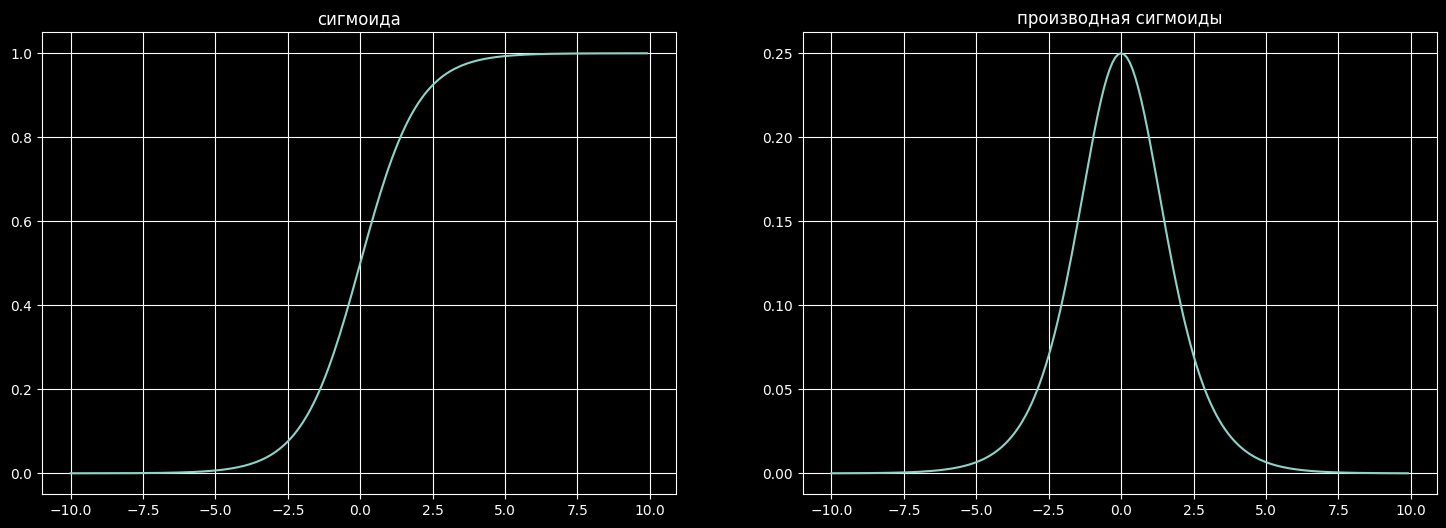

In [ ]:
# зададим массив чисел от -10 до 10
z = np.arange(-10,10,0.1)

plt.figure(figsize=(18,6))
plt.subplot(121);
plt.plot(z,sigmoid(z)); plt.title('сигмоида')
plt.grid()
plt.subplot(122);
plt.plot(z,sigmoid_derivative(z)); plt.title('производная сигмоиды')
plt.grid()

Как правило, после расчета функции активации мы должны округлить значения до 0 или до 1. То есть до значения метки одного из классов. Такое округление можно сделать по заданному порогу результатов функции активации. Например, мы можем сказать, что если значение сигмоида больше 0.5 то пусть будет класс 1, а если меньше, то наоборот. Однако, на практике мы ставим более высокий порог, как правило 0.7 - 0.8. Запишем функцию определения класса.

Отметим, что в описанном смысле можно говорить о том, что результат сигмоида - это вероятность того, что аргумент функции (z) принадлежит одному из классов. Также отметим, что такой аргумент принято называть логит.



In [ ]:
def to_class(logit, threshold = 0.7):
    # функция для принятия решения о классификации
    # сравниваем с порогом - если больше, то метка класса 1, если меньше - то 0
    return (logit>=threshold)*1

Рассмотрим несколько примеров

In [ ]:
print( to_class(sigmoid(0.5), threshold = 0.6), ',',  to_class(sigmoid(-2.5), threshold = 0.7) )

1 , 0


Отметим, что для расчета функции потерь не следует пользоваться округлением до классов

Теперь рассмотрим функцию потерь. Отметим, что значениях логорифма мы ввели небольшую константу с целью исключить ошибку вида логорифм нуля.

In [ ]:
_EPS_ = 1e-6
def bce_loss(yhat, y):
    # функция для оценки бинарной кросс-энтропии
    # опять "формула из учебника" с использованием библиотеки numpy
    # небольшой добавка _EPS_ - чтобы был не строго 0 под знаком логарифма. Нам бесконечности не нужны
    return -(y*np.log(yhat + _EPS_)+(1 - y)*np.log(1 - yhat + _EPS_)).mean()

для начала рассмотрим значение функции активации для предельных случаев значений вероятности.

In [ ]:
print('Неопределенность - попали ровно в 0.5 (yhat=0.5, y=1):\t %.3f'%bce_loss(yhat=0.5, y=1))
print('Неопределенность - попали ровно в 0.5 (yhat=0.5, y=0):\t %.3f'%bce_loss(yhat=0.5, y=0))
print('Правильно предсказываем 0 класс (yhat=0, y=0):\t %.3f'%bce_loss(yhat=0.0, y=0))
print('Правильно предсказываем 1 класс (yhat=1, y=1):\t %.3f'%bce_loss(yhat=1, y=1))
print('Неправильно предсказываем 0 класс (yhat=0, y=1):\t %.3f'%bce_loss(yhat=0.0, y=1))
print('Неправильно предсказываем 1 класс (yhat=1, y=0):\t %.3f'%bce_loss(yhat=1, y=0))

Неопределенность - попали ровно в 0.5 (yhat=0.5, y=1):	 0.693
Неопределенность - попали ровно в 0.5 (yhat=0.5, y=0):	 0.693
Правильно предсказываем 0 класс (yhat=0, y=0):	 -0.000
Правильно предсказываем 1 класс (yhat=1, y=1):	 -0.000
Неправильно предсказываем 0 класс (yhat=0, y=1):	 13.816
Неправильно предсказываем 1 класс (yhat=1, y=0):	 13.816


Запишем все в один класс. Также добавим в функцию эластичную регуляризацию.

In [ ]:
_EPS_ = 1e-6

class LogisticRegression(ElasticRegression):
    # унаследуем всё что можно от модели линейной регрессии с эластичной регуляризацией
    def __init__(self,
                 learning_rate = 0.5,
                 l1_penalty    = 0.0,
                 l2_penalty    = 0.0,
                 epochs        = 100,
                 weights       = None,
                 bias          = None,
                 threshold     = 0.5,
                 batch_size    = 1000,
                 n_batches     = None,
                 random_state  = 42):

        super().__init__(learning_rate = learning_rate,
                         epochs = epochs,
                         weights = weights,
                         bias    = bias,
                         batch_size   = batch_size,
                         n_batches    = n_batches,
                         random_state = random_state,
                         l1_penalty = l1_penalty,
                         l2_penalty = l2_penalty)
        self.learning_rate = learning_rate/2
        self.threshold = threshold
    #---------------------------------
    def loss(self,yhat, y):
        # изменяем функцию потерь - на бинарную кросс-энтропию
        l1_term = self.l1_penalty*np.sum(self.weights[1:])
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))
        # добавки от регуляризации остаются прежде
        return -(y*np.log(yhat  + _EPS_)+(1 - y)*np.log(1 - yhat  + _EPS_)).mean()\
            + l1_term+ l2_term
    #---------------------------------
    def sigmoid(self, z):
        # определение функции сигмоиды
        return 1 / (1 + np.exp(-z))
    #---------------------------------
    def forward(self, X):
        # умножаем признаки на веса и применяем к результату сигмоиду
        return self.sigmoid(np.dot(X, self.weights))
    #---------------------------------
    def to_class(self,logit):
        # классифицируем сравнивая с порогом
        return (logit>=self.threshold)*1
    #---------------------------------
    def predict(self, X):
        # предсказание модели
        # в этот раз в два этапа
        yhat = self.forward(self.add_bias(X)) # 1 - считаем модель
        return self.to_class(yhat) # 2 классифицируем по порогу

    #---------------------------------
    def predict_prob(self, X):
        # предсказание модели, но в "вероятностном виде"
        yhat = self.forward(self.add_bias(X))
        return yhat # для этого просто возвращаем модель
    #---------------------------------
    def score(self, X, y):
        # оценка модели
        yhat  = self.predict(X)
        return sum((yhat==y)*1)/y.size # по количеству совпавших предсказаний - Accuracy
    #---------------------------------
    def plot_desicion_function(self,X,y,figsize = (12,6),
                               marker = 'o',colors =("#FF0000", '#0000FF'),
                               alpha=0.7, s = 150, poly = False, order = 2):
        # отрисовка функции принятия решений
        plt.figure(figsize = figsize) # создаем новое полотно
        cm_bright = ListedColormap(colors) # создаем цветовую карту
        # отрисовыаем исходные данные
        plt.scatter(X[:, 0], X[:, 1],marker = marker, c=y, cmap=cm_bright,s = s, alpha =alpha);

        h =  (X[:, 0].max() - X[:, 0].min())/50 # шаг сетки как 1/50 от разницы между минимумом и максимумом
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5 # фиксируем минимальные и максимальные значения по горизонтали
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5 # фиксируем минимальные и максимальные значения по вертикали
        # создаем пары "иксов и игреков" (горизонтальных и вертикальных признаков)
        # равномерно распределенных от минимальных до максимальных значений с шагом h
        # т.е. мы разбиваем область значений входных данных на равномерную сетку
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                            np.arange(y_min, y_max, h))
        if poly: # небольшой спойлер - если мы используем полиномиальные признаки
        # то нашу сетку нужно преобразовать в соответсвующие полиномы. иначе модель нас не поймет
            # считаем предсказание модели в "вероятностном виде"
            # с помощью метода ravel "выпрямляем" сетку в столбцы
            Z = self.predict_prob(to_polynom(np.c_[xx.ravel(), yy.ravel()],order))-0.5
            # вычитаем 0.5, чтобы центровать вероятности: если модель не уверена, то будет 0
        else:
            # считаем предсказание модели в "вероятностном виде"
            # с помощью метода ravel "выпрямляем" сетку в столбцы
            Z = self.predict_prob(np.c_[xx.ravel(), yy.ravel()])-0.5
            # вычитаем 0.5, чтобы центровать вероятности: если модель не уверена, то будет 0
        cm = plt.cm.RdBu #
        Z = Z.reshape(xx.shape) # обратно преобразуем строку в сетку
        plt.contourf(xx, yy, Z, cmap=cm, alpha=.5) # отрисовываем контур вероятности
        plt.xticks([],[])
        plt.yticks([],[])
        plt.tight_layout()
    #---------------------------------
    def classification_report(self, X,y):
        # считаем различные метрики классификации
        tp = 0 # true_positives
        tn = 0 # true_negatives
        fp = 0 # false_positives
        fn = 0 # false_negatives

        yhat  = self.predict(X)
        total = yhat.size
        n= sum(yhat==0)
        p = sum(yhat==1)
        # перебираем все точки и в ручную заполняем матрицу ошибок
        for yhati,yi in zip(yhat,y):
            if yi == 1 and yhati == 1:
                tp += 1
            elif yi == 0 and yhati == 0:
                tn += 1
            elif yi == 1 and yhati == 0:
                fn += 1
            elif yi == 0 and yhati == 1:
                fp += 1
        # пишем все метрики
        print('True Positives:%.4f'%(tp/p), end = '\t')
        print('False Positives:%.4f'%(fp/p))
        print('False Negatives:%.4f'%(fn/n), end = '\t')
        print('True Negatives:%.4f'%(tn/n))
        print('Accuracy:%.4f'% ((tp + tn) / total))
        print('Recall:%.4f'% (tp / (tp + fn)), end = '\t')
        print('Precision:%.4f'%(tp / (tp + fp)))
        print('f1 measure:%.4f'%(tp / (tp + 0.5*(fp+fn))))

Подготовим данные для классификации

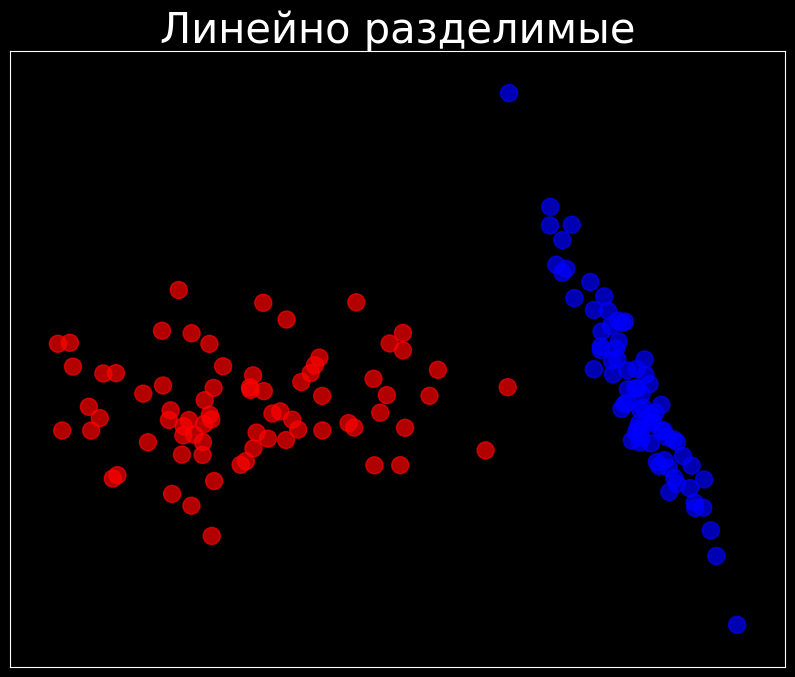

In [ ]:
X,y = make_binary_clf(N,method = 'line') # начнем с простого случая Линейно-разделимых данных

# никогда не забываем хотя бы разделять на тренировочную и тестовую (валидационную)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# визуализируем
fig = plt.figure(figsize= (10,8))
ax = plt.subplot(1, 1, 1)
plot_data(ax,(X,y),
          'Линейно разделимые')

Проведем тестирование без регуляризации по отработанной стратегии

* Создаем модель-объект

* Обучаем через `.fit()`

* Оцениваем через `.score()`

* Рисуем функцию потерь через `.plot_cost()`

добавляется пункт

* Оценка метрик классификации через `.classification_report()`

In [ ]:
regr = LogisticRegression(learning_rate=0.25,
                          epochs=500,batch_size=50,
                          )

regr.fit(X_train, y_train)

regr.plot_cost()

print(regr.score(X_test, y_test), regr.score(X_train, y_train))

regr.classification_report(X_test, y_test)

1.0 0.9904761904761905
True Positives:1.0000	False Positives:0.0000
False Negatives:0.0000	True Negatives:1.0000
Accuracy:1.0000
Recall:1.0000	Precision:1.0000
f1 measure:1.0000


Веса модели

In [ ]:
w, b = regr.get_w_and_b()
print(w,b)

[5.11587232 0.11673627] -3.4558633997289356


In [ ]:
vis_weigths(np.hstack([b,w]))

Отрисуем функцию принятия решений

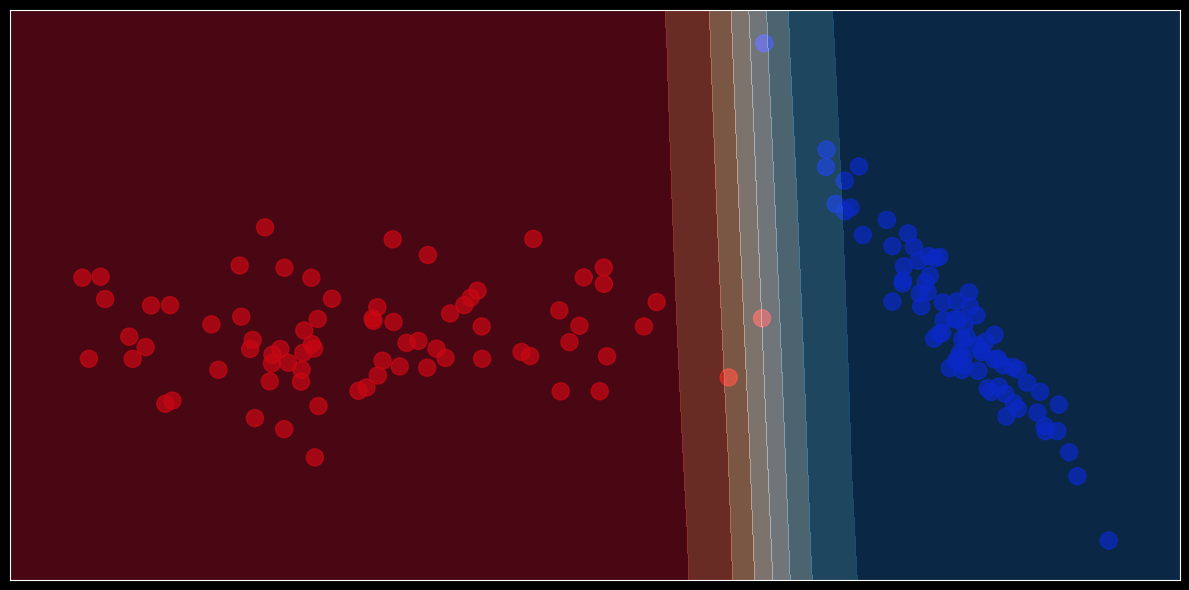

In [ ]:
regr.plot_desicion_function(X,y)

# Для более сложных данных

* Создаем набор данных (в этот раз круги)

* разбиваем на тренировочную и тестовую

* визуализируем

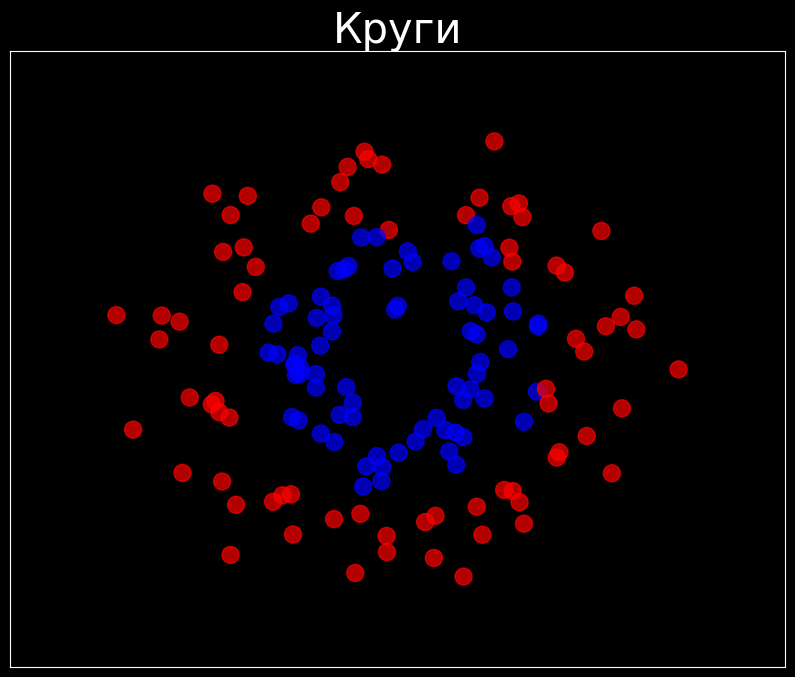

In [ ]:
X,y = make_binary_clf(N,method = 'circles')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

fig = plt.figure(figsize= (10,8))
ax = plt.subplot(1, 1, 1)
plot_data(ax,(X,y),
          'Круги')


Предвосхищая, что у нас ничего не получится подготовим функцию для генерации полиномиальных признаков

По образу и подобию той функции, которую мы использовали в Линейной регрессии

In [ ]:
def to_polynom(X, order = 2):
    """Генерация полиномиальных признаков .
    Входные переменные:
    ===========
    X: признаки
    order: порядок полинома
    """
    if order <2: # чтобы не пытались вставить отрицательные степени
        order = 2

    order_range = range(2, order+1,1)
    out = np.copy(X)
    for i in order_range:
        out = np.hstack([out, np.power(X,i)]) # складываем в выходную переменную все степени от 2 до order
    return out

Проверим на полиноме второй степени

По теории - должно хватить

In [ ]:
X_poly   = to_polynom(X, order = 2)  # из исходых данных генерируем полиномы второй степени

#  не забываем хотя бы разделять на тренировочную и тестовую (валидационную)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)


А дальше по отработанной схеме

* Создаем модель-объект

* Обучаем через `.fit()`

* Оцениваем через `.score()`

* Рисуем функцию потерь через `.plot_cost()`

* Оцениваем метрики классификации через `.classification_report()`

In [ ]:
regr = LogisticRegression(learning_rate=0.25,
                          epochs=500,batch_size=50,
                          )

regr.fit(X_train, y_train)

regr.plot_cost()

print(regr.score(X_test, y_test), regr.score(X_train, y_train))

regr.classification_report(X_test, y_test)

1.0 0.9714285714285714
True Positives:1.0000	False Positives:0.0000
False Negatives:0.0000	True Negatives:1.0000
Accuracy:1.0000
Recall:1.0000	Precision:1.0000
f1 measure:1.0000


Модели

In [ ]:
w, b = regr.get_w_and_b()
print(w,b)

[  0.10966824   0.64392491 -10.42235733  -9.19618212] 5.71889018849271


In [ ]:
vis_weigths(np.hstack([b,w]))

Отрисуем функцию принятия решений

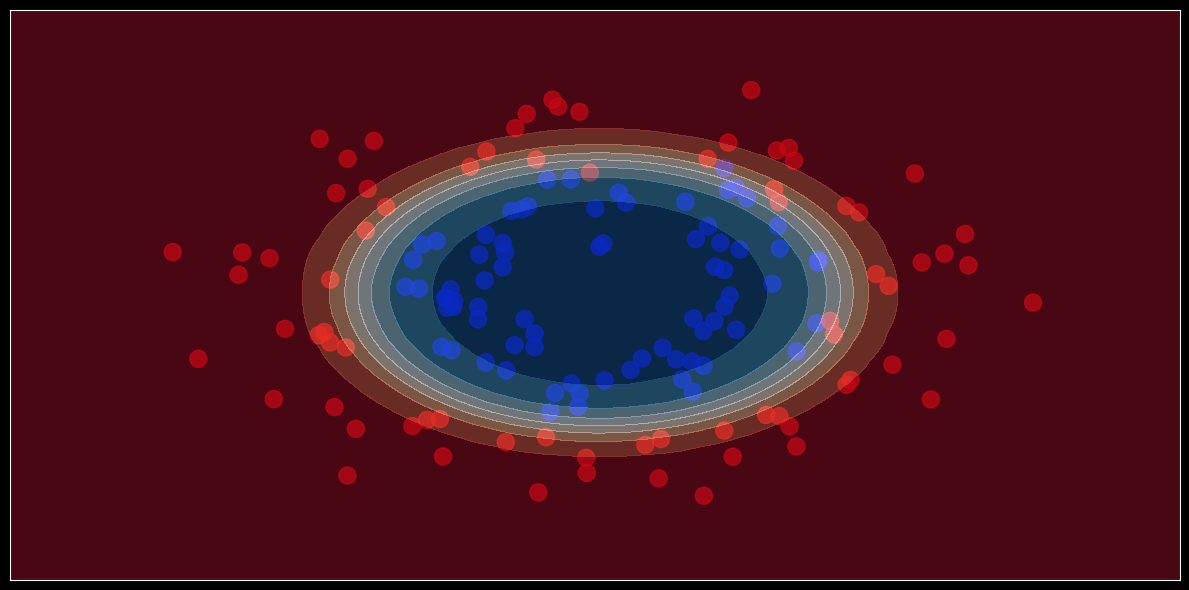

In [ ]:
regr.plot_desicion_function(X_poly,y,
                            poly = True, order = 2)


Удивительно, но всё работает